In [1]:
from IPython.utils import io

with io.capture_output() as captured:
    %run "CreditDecisionEngine.ipynb"

print("Credit Decision Engine Fully Loaded.")
print(f"   - Functions Imported: get_decision_explanation, visualize_decision")
print(f"   - Data Imported: elite_customer, risk_model, etc.")

Credit Decision Engine Fully Loaded.
   - Functions Imported: get_decision_explanation, visualize_decision
   - Data Imported: elite_customer, risk_model, etc.


In [2]:
def parse_factors(factors):
    rows = []
    for f in factors:
        name, val = f.rsplit(" (", 1)
        val = float(val.replace(")", ""))
        rows.append({
            "feature": name.strip(),
            "impact": round(val, 3),
            "direction": "Positive" if val > 0 else "Negative"
        })
    return rows
 

def parse_simple(items):
    return [{"signal": i} for i in items]


def generate_meaning(factors):
    meanings = []
    for f in factors:
        name, val = f.rsplit(" (", 1)
        val = float(val.replace(")", ""))
        if val < 0:
            meanings.append(f"{name.strip()} reduces risk")
        else:
            meanings.append(f"{name.strip()} increases risk")
    return meanings


def build_narrative(result):

    blocks = []

    # -------- PD BLOCK --------
    pd = result["PD"]["value"]
    blocks.append({
        "title": "Probability of Default (PD)",
        "value": pd,
        "status": "Very Low" if pd < 0.2 else "High",
        "summary": f"System estimates {round(pd*100,1)}% chance of default.",
        "table": parse_factors(result["PD"]["top_factors"]),
        "meaning": generate_meaning(result["PD"]["top_factors"])
    })

    # -------- ANOMALY BLOCK --------
    score = result["Anomaly"]["score"]
    blocks.append({
        "title": "Anomaly Detection",
        "value": score,
        "status": "Normal" if score > 0 else "Suspicious",
        "summary": "Behavior classified as normal" if score > 0 else "Unusual behavior detected",
        "table": parse_factors(result["Anomaly"]["top_factors"]),
        "meaning": generate_meaning(result["Anomaly"]["top_factors"])
    })

    # -------- RISK BLOCK --------
    blocks.append({
        "title": "Risk Classification",
        "value": result["RiskLabel"]["label"],
        "summary": f"Customer classified as {result['RiskLabel']['label']} risk.",
        "table": parse_simple(result["RiskLabel"]["drivers"])
    })

    # -------- SCORE BLOCK --------
    blocks.append({
        "title": "Hybrid Credit Score",
        "value": result["HybridScore"]["value"],
        "summary": f"Final score = {result['HybridScore']['value']}",
        "table": parse_factors(result["HybridScore"]["factors"])
    })

    # -------- RL BLOCK --------
    blocks.append({
        "title": "RL Recommendation",
        "value": result["RL_Recommendation"]["action"],
        "summary": f"System recommends: {result['RL_Recommendation']['action']}",
        "table": parse_simple(result["RL_Recommendation"]["rationales"])
    })

    return blocks

# Build narrative
narrative_blocks = build_narrative(get_decision_explanation(elite_customer))

print("Frontend Ready Explanation Blocks:")
print(json.dumps(narrative_blocks, indent=2))


Frontend Ready Explanation Blocks:
[
  {
    "title": "Probability of Default (PD)",
    "value": 0.0,
    "status": "Very Low",
    "summary": "System estimates 0.0% chance of default.",
    "table": [
      {
        "feature": "Monthly Expense Burden",
        "impact": -5.416,
        "direction": "Negative"
      },
      {
        "feature": "Existing Debt Commitments (EMI)",
        "impact": -2.009,
        "direction": "Negative"
      },
      {
        "feature": "Historical Payment Bounces",
        "impact": -0.309,
        "direction": "Negative"
      }
    ],
    "meaning": [
      "Monthly Expense Burden reduces risk",
      "Existing Debt Commitments (EMI) reduces risk",
      "Historical Payment Bounces reduces risk"
    ]
  },
  {
    "title": "Anomaly Detection",
    "value": 0.0955,
    "status": "Normal",
    "summary": "Behavior classified as normal",
    "table": [
      {
        "feature": "Monthly Expense Burden",
        "impact": -1.447,
        "direction

In [3]:
import matplotlib.pyplot as plt

def visualize_decision(input_row):
    """Generates visual explanations (Waterfall, Force, & Bar plots) for a customer."""
    df_input = pd.DataFrame([input_row])
    
    # --- 1. PD Waterfall Plot ---
    X_pd = pd_scaler.transform(df_input[pd_features])
    pd_exp = pd_explainer(X_pd)
    pd_exp.feature_names = [BUSINESS_MAPPING.get(f, f) for f in pd_features]
    
    plt.figure(figsize=(10, 4))
    plt.title("Probability of Default: Key Logic Flow")
    shap.waterfall_plot(pd_exp[0], show=False)
    plt.show()

    # --- 2. Anomaly Detection Force Plot ---
    X_if = if_scaler.transform(df_input[if_features])
    if_exp = if_explainer(X_if)
    if_exp.feature_names = [BUSINESS_MAPPING.get(f, f) for f in if_features]
    
    # Force plot usually works best for anomaly scores (output value)
    print("Anomaly Detection Logic:")
    shap.plots.force(if_exp[0], matplotlib=True, show=False)
    plt.show()

    # --- 3. Risk Classification Waterfall ---
    # Re-calculate intermediate signals for Risk Model
    pd_val = pd_model.predict_proba(X_pd)[0, 1]
    if_score = iso_model.decision_function(X_if)[0]
    anomaly_flag = 1 if if_score < -0.05 else 0
    
    df_risk = df_input.copy()
    df_risk['PD'] = pd_val
    df_risk['anomalyFlag'] = anomaly_flag
    X_risk = df_risk[risk_features]
    
    risk_pred_idx = int(risk_model.predict(X_risk)[0])
    risk_label = ["LOW", "MEDIUM", "HIGH"][risk_pred_idx]
    
    risk_exp = risk_explainer(X_risk)
    risk_exp.feature_names = [BUSINESS_MAPPING.get(f, f) for f in risk_features]
    
    # Handle multiclass output selection
    if hasattr(risk_exp, 'values') and risk_exp.values.ndim == 3:
        shap_vals_class = risk_exp[:, :, risk_pred_idx]
    else:
        shap_vals_class = risk_exp
        
    plt.figure(figsize=(10, 4))
    plt.title(f"Risk Classification: {risk_label}")
    shap.plots.waterfall(shap_vals_class[0], show=False)
    plt.show()

    # --- 4. Hybrid Score Bar Plot ---
    X_hyb = df_input[hybrid_features]
    hyb_exp = hybrid_explainer(X_hyb)
    hyb_exp.feature_names = [BUSINESS_MAPPING.get(f, f) for f in hybrid_features]
    
    plt.figure(figsize=(10, 4))
    plt.title("Hybrid Credit Score: Top Drivers")
    shap.plots.bar(hyb_exp[0], show=False)
    plt.show()

print('✅ Visual Explainability (Graph) function ready (PD, Anomaly, Risk, Hybrid).')

✅ Visual Explainability (Graph) function ready (PD, Anomaly, Risk, Hybrid).


--- Visual Graph Explanation ---


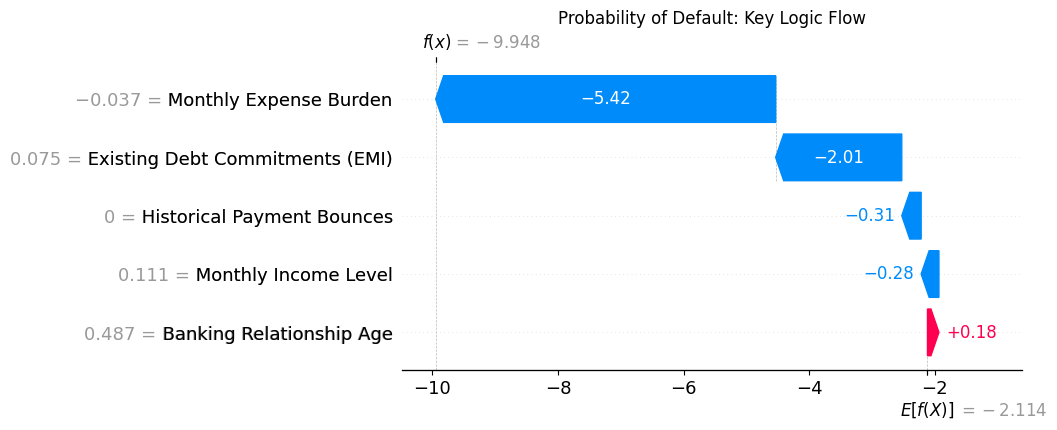

Anomaly Detection Logic:


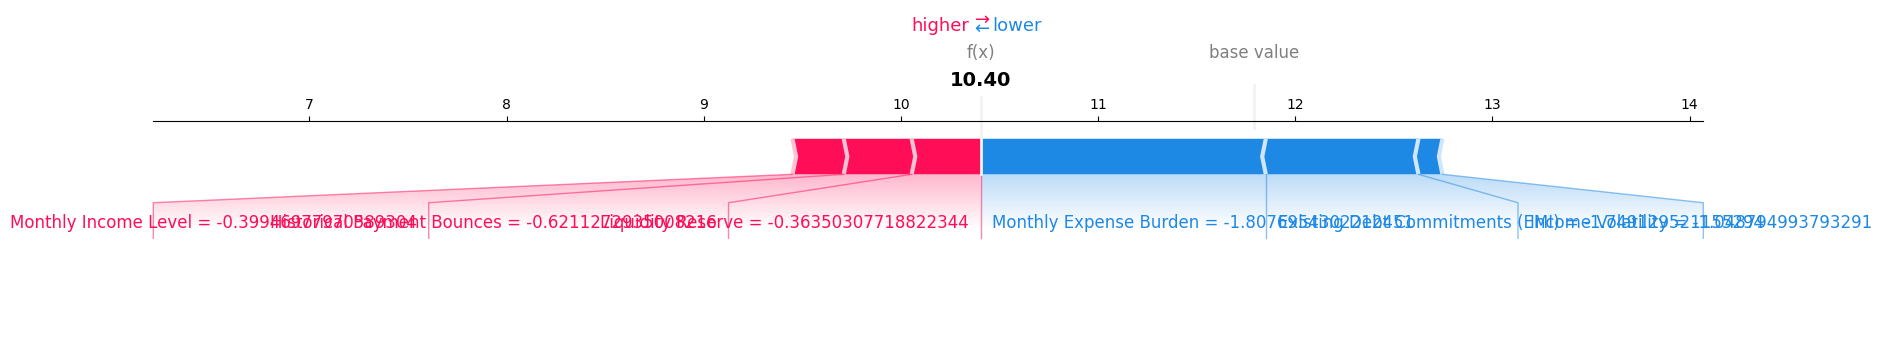

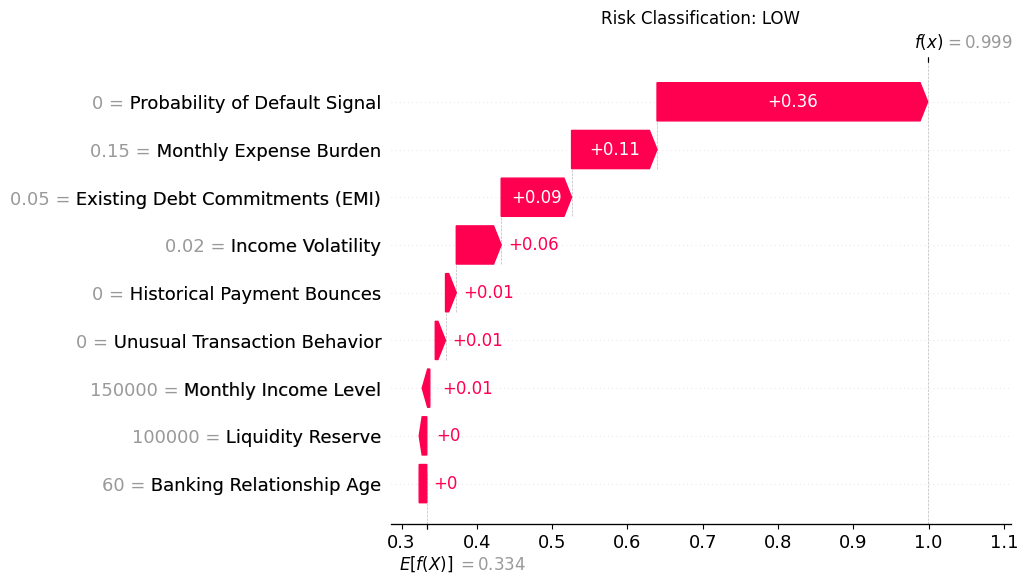

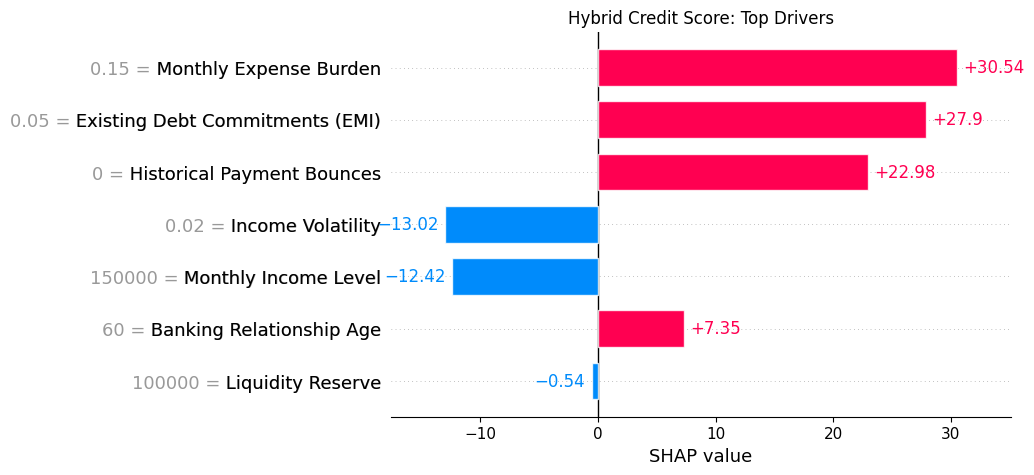

In [4]:
print('--- Visual Graph Explanation ---')
visualize_decision(elite_customer)